# Learning Rate Finder
> Implementation of the LR Range test from Leslie Smith

- toc: true
- badges: true
- author: Austin Chen
- categories: [optimizer,learning rate]

Learning rate finder plots lr vs loss relationship for a Learner. The idea is to reduce the amount of guesswork on picking a good starting learning rate.



## Load packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, History
from tensorflow.keras import backend as K

In [ ]:
# Reproducibility is important
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format="svg"

## Create a Keras callback for lr finder

In [ ]:
class LRFinder(Callback):
    """
    Learning rate finder. This is a part of 1-cycle policy where we try to find the 
    optimal learning rate for training a model. 
    """
    def __init__(self, 
                 base_lr=1e-5,
                 max_lr=10,
                 beta=0.98,
                 scale_min_loss=None,
                 nb_steps=None,
                 clip_initial_values=None,
                 clip_end_values=None):
        """
        Arguments:
            base_lr: Initial learning rate. Can be as low as 1e-8
            
            max_lr:  Maximum learning rate to be considered for the test. Although `high learning rate` 
                     is a model dependent thing. For example, for a 3-layer network 0.1 can be a pretty high 
                     learning rate. A value between 2-10 is fine and if you wish you can run the learning rate 
                     test for more than one maximum value.
            
            beta:     Smoothening parameter for moving average of loss values. Better not to change the default value.
            nb_steps: Number of training steps/iterations in an epoch
            scale_min_loss: A value that is used to scale the minimum loss found yet to compare it with the
                            current loss. A value between 3-5 is found to be nominal 
            
            clip_initial_values: How many initial values to clip in the plots?
            clip_end_values: How many values to clip from the end in the plots?
        """
        super().__init__()
        assert nb_steps > 1, "Number of training steps should be greateer than 1"
        
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.beta = beta
        self.nb_steps = nb_steps
        self.min_loss = 0
        self.batch_num=0
        self.avg_loss=0
        self._lr_scaler = (max_lr / base_lr)**(1/(nb_steps-1))
        self.min_loss_scaler = scale_min_loss
        self.clip_initial_values = clip_initial_values
        self.clip_end_values = clip_end_values
        self.history = {}
    
    
    @property
    def lr_scaler(self):
        return (self.max_lr / self.base_lr)**(1/(self.nb_steps-1))
    
    
    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.batch_num == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
            
    def on_batch_begin(self, epoch, logs=None):
        self.batch_num+=1
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
    
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs["loss"]
        self.avg_loss = self.beta*self.avg_loss + (1-self.beta)*loss
        loss_smoothened = self.avg_loss/(1-self.beta**self.batch_num)
        
        if self.batch_num==1 or loss_smoothened < self.min_loss:
            self.min_loss = loss_smoothened
            
        self.history.setdefault('batch_loss', []).append(loss_smoothened)
        self.history.setdefault('lr', []).append(math.log10(self.base_lr))
        
        if self.min_loss_scaler:
            max_loss_check = self.min_loss_scaler*self.min_loss
        else:
            max_loss_check = 4*self.min_loss
            
        if self.batch_num>1 and (np.isnan(loss_smoothened) 
                                 or loss_smoothened > max_loss_check):
            print("LR range test complete")
            self.model.stop_training=True
            self.plot_values(self.history['lr'], self.history['batch_loss'])
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        self.base_lr*=self.lr_scaler
        K.set_value(self.model.optimizer.lr, self.base_lr)
        
    
    def plot_values(self,x,y):
        f,ax = plt.subplots(1,1, figsize=(8,5))
        if self.clip_initial_values:
            x = x[self.clip_initial_values:]
            y = x[self.clip_initial_values:]
        
        if self.clip_end_values:
            x = x[:self.clip_end_values]
            y = y[:self.clip_end_values]
        
        ax.plot(x, y)
        plt.title("LR_range test")
        plt.xlabel("Learning rate on log10 scale")
        plt.ylabel("Loss")
        plt.show()

## Load MNIST dataset

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

## Pre-processing

In [ ]:
# Pre-process the dataset
img_rows, img_columns, img_channels = 28,28,1
nb_classes=10

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Reshape the samples in the dataset as required by the model
x_train = x_train.reshape(x_train.shape[0], img_rows, img_columns, img_channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_columns, img_channels)

# convert class vectors to one hot-encoded vectors
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


## Build a model

In [ ]:
def build_simple_model(input_shape, opt=None):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    if opt:
        opt = opt
    else:
        opt = SGD()
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [ ]:
# Define batch size, number of epochs and number of training steps in an epoch
batch_size=32
nb_epochs =10
nb_steps = len(x_train)//batch_size
input_shape = (img_rows,img_columns,img_channels)

## Train a model without finding optimal lr

Let us train our model without searching for an optimal learning rate. We will be using the default learning rate for the optimizer

In [ ]:
# Build the model
model = build_simple_model(input_shape)

# Train the model
model.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 12s 3ms/step - loss: 0.9501 - accuracy: 0.6943
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3108 - accuracy: 0.9064
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2468 - accuracy: 0.9265
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1929 - accuracy: 0.9424
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1606 - accuracy: 0.9523
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1302 - accuracy: 0.9624
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1135 - accuracy: 0.9656
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1041 - accuracy: 0.9697
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0929 - accuracy: 0.9713
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.08

In [ ]:
# What is the accuracy for this model?
score = model.evaluate(x_test, y_test, verbose=0, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04629101976752281
Test accuracy: 0.9848999977111816


## Finding a good LR for our model

We will create an instance of the class we built above and pass it as a callback to our model. The LR finder is very cheap in terms of compute and it hardly takes an epoch or less to complete. We will keep the default values of `base_lr` and `max_lr` but you can change it if you want to. 

LR range test complete


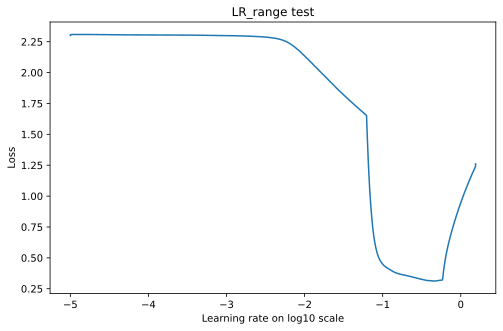

In [ ]:
# Get an instance of LRTest class
lr_finder = LRFinder(nb_steps=nb_steps)

# Build the model again
model2 = build_simple_model(input_shape)

# Perform the LR range test 
history = model2.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size, verbose=0, callbacks=[lr_finder])

Text(0.5, 0, 'Learning Rate')

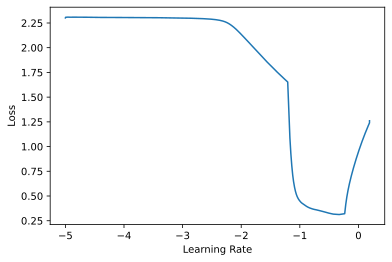

In [ ]:
lrs, losses = (lr_finder.history["lr"], lr_finder.history["batch_loss"])
_, ax = plt.subplots(1,1)
ax.plot(lrs, losses)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
#ax.set_xscale('log10')
#ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

The above plot shows two things:
* On the y-axis, you can see the batch loss during the training
* On the x-axis, you can see the value of learning rate(values on log10 scale) changing with every batch

The loss starts to decrease as the training starts and the loss value is minimum around a value of `-0.5` of lr on the x-axis. This shows that for this dataset, we can choose this value`(10**-0.5)` as the optimal value. Beyond `-0.5`, the loss starts to explode again. This is the point where we stop training the model anymore.

In order to avoid overfitting, we should choose a value of lr slightly lower than this. For example, instead of choosing `10**-0.5`, we will choose the value `10**-1` as the optimal value for our learning rate. This will make sure that we still take aggressive steps for faster training but not aggressive enough for the loss to explode.

## Train the model with the optimal lr found using LR finder

In [ ]:
# Build the model with the optimal lr
model3 = build_simple_model(input_shape, lr=10**-1)

# Train the model 
model3.fit(x_train, y_train, epochs=nb_epochs, batch_size=batch_size)

In [ ]:
# Evaluate
score = model3.evaluate(x_test, y_test, verbose=0, batch_size=batch_size)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.033560635694834216
Test accuracy: 0.9897


You can see that if we start with an optimal learning rate, we can coverge much faster. A good start always pays off! 

## Conclusion

In this notebook, we saw how we can implement a simple `LR finder` in keras. Keras gives you the hooks to implement almost anything seamlessly. Before writing anything from scratch, you should always check how can you use a hook to implement it in Keras first.

## References
* https://arxiv.org/abs/1708.07120
* https://arxiv.org/abs/1506.01186
* https://arxiv.org/abs/1803.09820
* https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

## 1% Better Everyday

Maybe we don't really need to create a class for learning rate finder. Perhaps we can achieve the same goal by using the [`tf.keras.optimizers.schedules.ExponentialDecay`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) plus tensor board.

- https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it
- https://medium.com/octavian-ai/how-to-use-the-learning-rate-finder-in-tensorflow-126210de9489
